<a href="https://colab.research.google.com/github/krishnamohan-seelam/ml_colab/blob/master/Fake_News_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
IN_COLAB = 'google.colab' in str(get_ipython())

In [2]:
if IN_COLAB:
  # Uninstall tensorflow first
  !pip uninstall tensorflow -y
  # Install tensorflow-gpu (stable version)
  !pip install tensorflow-gpu  # stable
  !pip install emoji
  import tensorflow as tf
  # Check version
  print(tf.__version__)

  from tensorflow.python.client import device_lib
  device_lib.list_local_devices()

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

2.4.0
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from tensorflow.keras.preprocessing.text import one_hot

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

import re
import string
import os
import emoji

import collections
import unicodedata


from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pprint import pprint
from time import time
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords, wordnet

from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, TweetTokenizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords, wordnet

from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, TweetTokenizer
from sklearn.feature_extraction import text

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
sk_learn_stopwords = text.ENGLISH_STOP_WORDS
nltk__stopwords = stopwords.words('english')
stop_words = sk_learn_stopwords.intersection(nltk__stopwords)

In [8]:
class CleanText(BaseEstimator, TransformerMixin):

    def __init__(self, stop_words, stemmer):
        self.stop_words = stop_words
        self.stemmer = stemmer
        self.tokenizer = TweetTokenizer()

    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)

    def remove_accented_chars(self, input_text):
        text = unicodedata.normalize('NFKD', input_text).encode(
            'ascii', 'ignore').decode('utf-8', 'ignore')
        return text

    def remove_urls(self, input_text):
        input_text = re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
        input_text = re.sub(r'^RT[\s]+', '', input_text)
        return input_text

    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_', '')

    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(
            punct,
            len(punct) *
            ' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)

    def to_lower(self, input_text):
        return input_text.lower()

    def remove_stopwords(self, input_text):

        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = self.tokenizer.tokenize(input_text)
        clean_words = [
            word for word in words
            if ((word.strip() not in self.stop_words) or word.strip() in whitelist)
        ]
        #clean_words = [CONTRACTION_MAP.get(word, word) for word in clean_words]
        return " ".join(clean_words)

    def remove_repeated_characters(self, input_text):

        repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
        match_substitution = r'\1\2\3'
        tokens = input_text.split()

        def replace(old_word):
            if wordnet.synsets(old_word):
                return old_word
            new_word = repeat_pattern.sub(match_substitution, old_word)
            return replace(new_word) if new_word != old_word else new_word

        correct_tokens = [replace(word) for word in tokens]

        return " ".join(correct_tokens)

    def remove_shortwords(self, input_text):
        words = self.tokenizer.tokenize(input_text)
        words = [word for word in words if 2 < len(word) < 20]
        return " ".join(words)

    def stemming(self, input_text):
        words = self.tokenizer.tokenize(input_text)
        if isinstance(self.stemmer, WordNetLemmatizer):
            stemmed_words = [self.stemmer.lemmatize(word) for word in words]
        else:
            stemmed_words = [self.stemmer.stem(word) for word in words]
        return " ".join(stemmed_words)

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        #clean_X = X.apply(self.remove_accented_chars)
        #clean_X = clean_X.apply(self.remove_mentions)
        #clean_X = clean_X.apply(self.remove_urls)
        #clean_X = clean_X.apply(self.emoji_oneword)
        clean_X = X.apply(self.remove_stopwords)
        clean_X = clean_X.apply(self.remove_punctuation)
        clean_X = clean_X.apply(self.remove_digits)
        # clean_X = clean_X.apply(self.remove_repeated_characters)
        clean_X = clean_X.apply(self.to_lower)

        clean_X = clean_X.apply(self.remove_shortwords)
        return clean_X

In [9]:
def get_filepath(foldername,filename):
  
  if IN_COLAB:
      from google.colab import drive
      drive.mount('/content/drive')
      data_path = 'drive/My Drive/datasets/{foldername}/{filename}'
      source_path = Path.cwd()
      return source_path.joinpath(data_path.format(foldername=foldername,filename=filename))
  else:
      data_path='{filename}'
      source_path =Path.cwd().joinpath('datasource')
      return source_path.joinpath(data_path.format(filename=filename))

In [10]:
foldername = 'fake-news'
train_file = get_filepath(foldername,'train.csv')
test_file  = get_filepath(foldername,'test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [12]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [13]:
train_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,20800,NaN,NaN,NaN,10399.5,6004.59,0,5199.75,10399.5,15599.2,20799
title,20242,19803,Get Ready For Civil Unrest: Survey Finds That ...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author,18843,4201,Pam Key,243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,20761,20386,,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label,20800,NaN,NaN,NaN,0.500625,0.500012,0,0,1,1,1


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
dtypes: int64(1), object(3)
memory usage: 162.6+ KB


In [16]:
train_df[train_df['text'].isna()] 

,id,title,author,text,label
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1
2169,2169,"#NDDL: Pour fêter l’autorisation des travaux, ...",NaN,NaN,1
2793,2793,«Pourquoi je suis candidat à la présidentielle...,NaN,NaN,1
3329,3329,GuinessBook : 100 millions d’Américains batten...,NaN,NaN,1
3729,3729,Les Américains ne sont plus qu’à quelques heur...,NaN,NaN,1
4288,4288,Hillary Clinton en 5 dates >> Le Gorafi,NaN,NaN,1


In [17]:
test_df[test_df['text'].isna()] 

,id,title,author,text
589,21389,[Vidéo] Que trouve-t-on dans « Le Gorafi de l’...,NaN,NaN
626,21426,Nous avons comparé les programmes d’Alain Jupp...,NaN,NaN
978,21778,« J’y crois encore ! » par Alain Juppé en trai...,NaN,NaN
2257,23057,Horoscope du 14 novembre 2016 >> Le Gorafi,NaN,NaN
2892,23692,Une fan demande le remboursement de son tatoua...,NaN,NaN
4736,25536,Révélations – François Fillon serait de droite...,NaN,NaN
5092,25892,Des traces de vin rouge détectées dans le Beau...,NaN,NaN


In [18]:
def impute_text(row):
  return row['title']

In [19]:
train_df['text'].fillna(train_df[train_df['text'].isnull()].apply(impute_text, axis=1), inplace=True)

In [20]:
test_df['text'].fillna(test_df[test_df['text'].isnull()].apply(impute_text, axis=1), inplace=True)



In [21]:
stemmer = PorterStemmer()
ct = CleanText(stop_words, stemmer)
train_df['clean_text'] = ct.fit_transform(train_df['text'])
test_df['clean_text'] = ct.transform(test_df['text'])

In [22]:
train_df.head()

,id,title,author,text,label,clean_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didn even see comey letter unti...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,why truth might get you fired october the tens...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,videos civilians killed single airstrike have ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...


In [23]:
MAX_TEXT_LEN  = max(max(train_df['clean_text'].map(len)),max(test_df['clean_text'].map(len)))

In [24]:
MAX_TEXT_LEN

126513

In [25]:
clean_text= train_df['clean_text'].values

In [26]:
tokenizer = Tokenizer(num_words=7000)
tokenizer.fit_on_texts(clean_text)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(clean_text)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [27]:
from keras.callbacks import ModelCheckpoint
model_filename = 'fakenews_best_weights_'+str(int(dt.utcnow().timestamp()*100))+'.hdf5'
filepath = get_filepath(foldername,filename=model_filename)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
vocab_size = 7000

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout,Bidirectional
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
embedding_vector_length = 40
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length,     
                                     input_length=200) )
# model.add(SpatialDropout1D(0.25))
#model.add(LSTM(12, dropout=0.25, recurrent_dropout=0.25))
model.add(Bidirectional(LSTM(100,dropout=0.3,recurrent_dropout=0.3)))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 40)           280000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 393,001
Trainable params: 393,001
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
model_history = model.fit(padded_sequence,train_df['label'].values,
                  validation_split=0.25, epochs=10, batch_size=64,callbacks=callbacks_list)

Epoch 1/10
244/244 [==============================] - 244s 979ms/step - loss: 0.4858 - accuracy: 0.7452 - val_loss: 0.1998 - val_accuracy: 0.9256

Epoch 00001: val_accuracy improved from -inf to 0.92558, saving model to /content/drive/My Drive/datasets/fake-news/fakenews_best_weights_161090438705.hdf5
Epoch 2/10
244/244 [==============================] - 237s 973ms/step - loss: 0.1420 - accuracy: 0.9492 - val_loss: 0.1861 - val_accuracy: 0.9308

Epoch 00002: val_accuracy improved from 0.92558 to 0.93077, saving model to /content/drive/My Drive/datasets/fake-news/fakenews_best_weights_161090438705.hdf5
Epoch 3/10
244/244 [==============================] - 239s 980ms/step - loss: 0.0900 - accuracy: 0.9715 - val_loss: 0.1982 - val_accuracy: 0.9352

Epoch 00003: val_accuracy improved from 0.93077 to 0.93519, saving model to /content/drive/My Drive/datasets/fake-news/fakenews_best_weights_161090438705.hdf5
Epoch 4/10
244/244 [==============================] - 238s 975ms/step - loss: 0.0577 

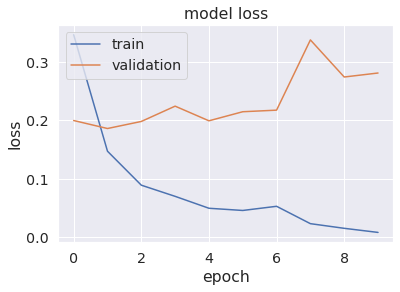

In [31]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

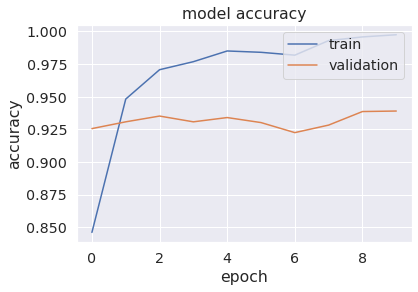

In [32]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [33]:
model.load_weights(filepath)

In [34]:
test_text = test_df['clean_text'].values
encoded_docs = tokenizer.texts_to_sequences(test_text)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [35]:
y_pred = model.predict_classes(padded_sequence)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [36]:
y_pred =y_pred.flatten()

In [37]:
submission_df = pd.DataFrame(test_df['id'])

In [38]:
submission_df['label'] =y_pred

In [39]:
filename  = 'submission_text_'+str(int(dt.utcnow().timestamp()*100)) +'.csv' 
filename

'submission_text_161090678699.csv'

In [40]:
submission_file = get_filepath(foldername,filename=filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
submission_df.to_csv(submission_file,index=False)